In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from pathlib import Path
import pandas as pd
import numpy as np

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Row, Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from synapse.ml.lightgbm import *

pio.renderers.default = "iframe"

In [2]:
def calculate_distribution_mean(slope: float,
                                x_min: float,
                                x_max: float):
    scaling = 1 / (1 - (x_min / x_max)**slope)
    return (scaling * slope / (1 - slope)) * (x_max*(x_min/x_max)**slope - x_min)

def fix_up_df(df: pd.DataFrame):
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["x_min"] = 5
    df["x_max"] = 1000
    df["exp_mean_r"] = calculate_distribution_mean(df.slope, df.x_min, df.x_max)
    df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)
    df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
    
    df["slope_center_to_center_nearest_neighbor_distance_mean"] = df.slope * df.center_to_center_nearest_neighbor_distance_mean
    df["exp_mean_r_n_craters_in_study_region"] = df.exp_mean_r * df.n_craters_in_study_region
    df["slope_exp_mean_r"] = df.slope * df.exp_mean_r
    df["exp_mean_r_areal_density"] = df.exp_mean_r * df.areal_density
    df["exp_mean_r_center_to_center_nearest_neighbor_distance_mean"] = df.exp_mean_r * df.center_to_center_nearest_neighbor_distance_mean
    df["exp_slope"] = 10**df.slope
    df["exp_slope_center_to_center_nearest_neighbor_distance_mean"] = df.exp_slope * df.center_to_center_nearest_neighbor_distance_mean
    
    df["log_stdev_N"] = np.log10(np.sqrt(df.variance))

        
    return df[df.isna().sum(axis=1) == 0].reset_index(drop=True).copy()

In [3]:
base_path = "/data/saturation/n_craters_stop_condition_20230918"

ivs = [
    "slope",
    "effective_radius_multiplier",
    "r_stat_multiplier",
    "min_rim_percentage",
    "z",
    "za",
    "n_craters_in_study_region",
    "exp_mean_r",
    # "log_exp_mean_r",
    # "log_n_craters_in_study_region",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "slope_center_to_center_nearest_neighbor_distance_mean",
    "exp_mean_r_n_craters_in_study_region",
    "slope_exp_mean_r",
    "exp_mean_r_areal_density",
    "exp_mean_r_center_to_center_nearest_neighbor_distance_mean",
    # "log_center_to_center_nearest_neighbor_distance_mean",
    # "log_center_to_center_nearest_neighbor_distance_stdev",
    # "log_center_to_center_nearest_neighbor_distance_max",
    "radius_mean",
    "radius_stdev",
    # "log_radius_mean",
    # "log_radius_stdev",
]

In [4]:
# n_simulations = 2500
# sample_size = 500

# train_df = pd.read_parquet(f"{base_path}/train_{n_simulations}_{sample_size}.parquet")
# train_df = fix_up_df(train_df)

# test_df = pd.read_parquet(f"{base_path}/test_{n_simulations}_{sample_size}.parquet")
# test_df = fix_up_df(test_df)

# metric = "post_saturation_n_craters_in_study_region_percentile"

In [5]:
train_df = pd.read_parquet(f"{base_path}/train_with_variance.parquet")
train_df = fix_up_df(train_df)

test_df = pd.read_parquet(f"{base_path}/test_with_variance.parquet")
test_df = fix_up_df(test_df)

metric = "log_stdev_N"

In [6]:
n_cores = 20

spark = SparkSession.builder \
                    .master(f"local[{n_cores}]") \
                    .appName("Saturation") \
                    .config("spark.driver.memory", "64g") \
                    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.11.2") \
                    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                    .getOrCreate()
sc = spark.sparkContext

23/10/12 16:06:27 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
23/10/12 16:06:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1


:: loading settings :: url = jar:file:/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mason/.ivy2/cache
The jars for the packages stored in: /home/mason/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a3fb3327-7b05-4c45-b513-b0396717d92a;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;0.11.2 in central
	found com.microsoft.azure#synapseml-core_2.12;0.11.2 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpmime;4.5.13 in central
	found org.apache.httpc

### LightGBM models

#### Baseline Model

In [7]:
def score_model(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 1):
    sampled = df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()
    
    X = poly_transform.transform(sampled[ivs])
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())
    X[metric] = sampled[metric]
    
    df_spark = spark.createDataFrame(X)
    spark_X = assembler.transform(df_spark)
    pred_df = model.transform(spark_X).toPandas()
    pred_df["simulation_id"] = df["simulation_id"]
    pred_df["slope"] = df["slope"]
    pred_df["n_craters_added_in_study_region"] = df["n_craters_added_in_study_region"]
    pred_df["effective_radius_multiplier"] = df["effective_radius_multiplier"]
    pred_df["min_rim_percentage"] = df["min_rim_percentage"]
    pred_df["r_stat_multiplier"] = df["r_stat_multiplier"]

    rmse = mean_squared_error(pred_df[metric], pred_df["prediction"], squared=False)
    mape = mean_absolute_percentage_error(pred_df[metric], pred_df["prediction"])
    mae = mean_absolute_error(pred_df[metric], pred_df["prediction"])
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

    residuals = pred_df[metric] - pred_df["prediction"]
    plt.hist(residuals, bins=50)
    plt.show()

    y_pred_mean_model = [df[metric].mean()] * df.shape[0]
    rmse = mean_squared_error(y_pred_mean_model, df[metric], squared=False)
    mape = mean_absolute_percentage_error(df[metric], y_pred_mean_model)
    mae = mean_absolute_error(y_pred_mean_model, df[metric])
    print(f"Mean model: RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")
    
    return pred_df


def plot_sim_ci(model,
                df: pd.DataFrame,
                metric: str,
                assembler: VectorAssembler,
                ivs: List[str],
                features: List[str],
                sample_cadence: int = 250):   
    # Show params
    print(f"Simulation parameters: {df[ivs].iloc[0]}")
    
    ns_max = 100000
    plt.plot(df.n_craters_added_in_study_region.iloc[:ns_max],
             df[metric].iloc[:ns_max])
    plt.xlabel("$N_S$")
    plt.ylabel("$A_d$")
    plt.show()

    pred_df = score_model(model, df, metric, assembler, ivs, features, sample_cadence)
   
    fig = go.Figure()
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["prediction"],
                    mode="lines",
                    name="95% Threshold")

    fig.update_layout(
        xaxis_title="$N_S$",
        yaxis_title=metric
    )

    fig.show()

23/10/12 16:06:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/10/12 16:06:53 WARN TaskSetManager: Stage 1 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.
23/10/12 16:06:54 WARN TaskSetManager: Stage 2 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.
23/10/12 16:07:04 WARN TaskSetManager: Stage 3 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.1102, MAE: 0.0647, MAPE: 0.2369


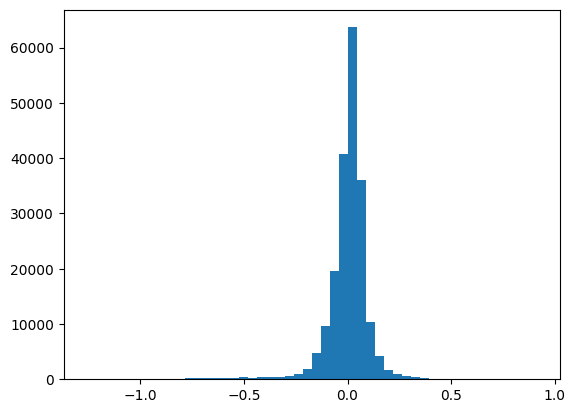

Mean model: RMSE: 0.1504, MAE: 0.0940, MAPE: 0.2980
Training % outside of range: 0.405
RMSE: 0.1097, MAE: 0.0654, MAPE: 0.1880


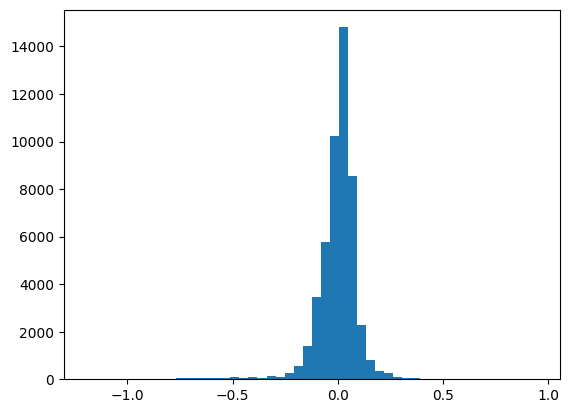

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584
Testing % outside of range: 0.427
Feature importances:
   slope_center_to_center_nearest_neighbor_distance_mean: 8.0
   exp_mean_r_areal_density: 6.0
   center_to_center_nearest_neighbor_distance_mean: 3.0
   za: 2.0
   exp_mean_r_center_to_center_nearest_neighbor_distance_mean: 1.0
   slope: 0.0
   effective_radius_multiplier: 0.0
   r_stat_multiplier: 0.0
   min_rim_percentage: 0.0
   z: 0.0
   n_craters_in_study_region: 0.0
   exp_mean_r: 0.0
   areal_density: 0.0
   areal_density_overlap_2: 0.0
   areal_density_overlap_3: 0.0
   center_to_center_nearest_neighbor_distance_stdev: 0.0
   center_to_center_nearest_neighbor_distance_min: 0.0
   center_to_center_nearest_neighbor_distance_max: 0.0
   exp_mean_r_n_craters_in_study_region: 0.0
   slope_exp_mean_r: 0.0
   radius_mean: 0.0
   radius_stdev: 0.0


In [8]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(5)
    .setNumLeaves(5)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_5_5 = model

23/10/12 16:07:20 WARN TaskSetManager: Stage 6 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.
23/10/12 16:07:20 WARN TaskSetManager: Stage 7 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.
23/10/12 16:07:30 WARN TaskSetManager: Stage 8 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.0702, MAE: 0.0419, MAPE: 0.1636


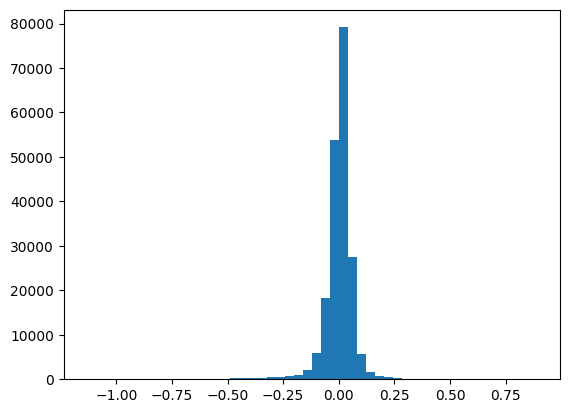

Mean model: RMSE: 0.1504, MAE: 0.0940, MAPE: 0.2980
Training % outside of range: 0.428
RMSE: 0.0724, MAE: 0.0425, MAPE: 0.1266


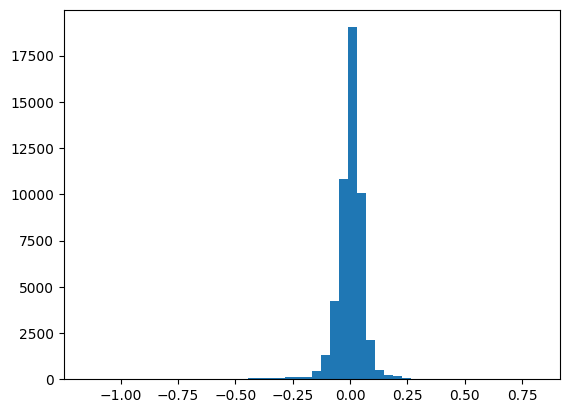

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584
Testing % outside of range: 0.444
Feature importances:
   slope_center_to_center_nearest_neighbor_distance_mean: 199.0
   slope: 84.0
   center_to_center_nearest_neighbor_distance_mean: 49.0
   exp_mean_r_center_to_center_nearest_neighbor_distance_mean: 47.0
   exp_mean_r_areal_density: 35.0
   slope_exp_mean_r: 29.0
   za: 11.0
   effective_radius_multiplier: 8.0
   min_rim_percentage: 4.0
   areal_density_overlap_3: 4.0
   center_to_center_nearest_neighbor_distance_stdev: 4.0
   r_stat_multiplier: 3.0
   center_to_center_nearest_neighbor_distance_max: 3.0
   exp_mean_r_n_craters_in_study_region: 3.0
   n_craters_in_study_region: 2.0
   areal_density: 2.0
   radius_mean: 2.0
   radius_stdev: 1.0
   z: 0.0
   exp_mean_r: 0.0
   areal_density_overlap_2: 0.0
   center_to_center_nearest_neighbor_distance_min: 0.0


In [9]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(10)
    .setNumLeaves(50)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_10_50 = model

23/10/12 16:07:45 WARN TaskSetManager: Stage 11 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.
23/10/12 16:07:45 WARN TaskSetManager: Stage 12 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.
23/10/12 16:07:55 WARN TaskSetManager: Stage 13 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.0669, MAE: 0.0404, MAPE: 0.1550


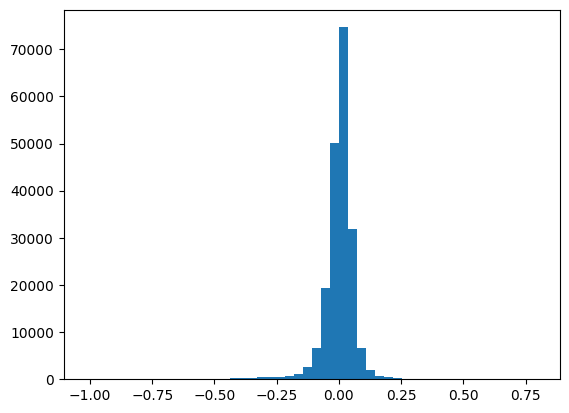

Mean model: RMSE: 0.1504, MAE: 0.0940, MAPE: 0.2980
Training % outside of range: 0.423
RMSE: 0.0699, MAE: 0.0412, MAPE: 0.1192


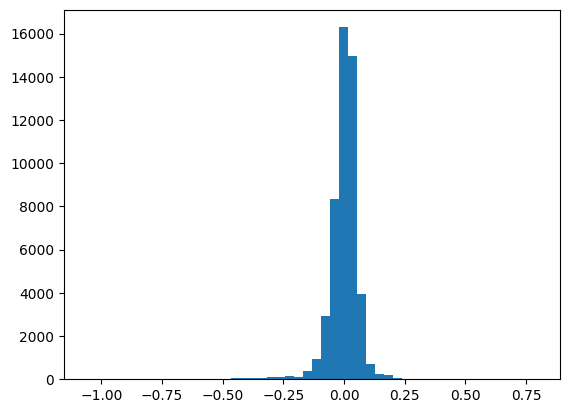

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584
Testing % outside of range: 0.440
Feature importances:
   slope_center_to_center_nearest_neighbor_distance_mean: 347.0
   slope: 200.0
   exp_mean_r_center_to_center_nearest_neighbor_distance_mean: 106.0
   center_to_center_nearest_neighbor_distance_mean: 97.0
   slope_exp_mean_r: 86.0
   exp_mean_r_areal_density: 37.0
   r_stat_multiplier: 18.0
   min_rim_percentage: 12.0
   za: 12.0
   effective_radius_multiplier: 11.0
   center_to_center_nearest_neighbor_distance_stdev: 10.0
   exp_mean_r_n_craters_in_study_region: 10.0
   center_to_center_nearest_neighbor_distance_max: 8.0
   exp_mean_r: 6.0
   areal_density: 6.0
   radius_mean: 5.0
   radius_stdev: 5.0
   areal_density_overlap_3: 4.0
   z: 3.0
   n_craters_in_study_region: 3.0
   areal_density_overlap_2: 2.0
   center_to_center_nearest_neighbor_distance_min: 2.0


In [10]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(10)
    .setNumLeaves(100)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_10_100 = model

23/10/12 16:08:10 WARN TaskSetManager: Stage 16 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.
23/10/12 16:08:10 WARN TaskSetManager: Stage 17 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.
23/10/12 16:08:20 WARN TaskSetManager: Stage 18 contains a task of very large size (1897 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.0341, MAE: 0.0217, MAPE: 0.0823


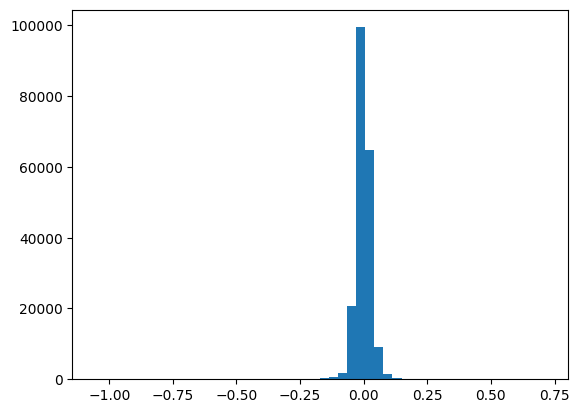

Mean model: RMSE: 0.1504, MAE: 0.0940, MAPE: 0.2980
Training % outside of range: 0.502
RMSE: 0.0428, MAE: 0.0242, MAPE: 0.0663


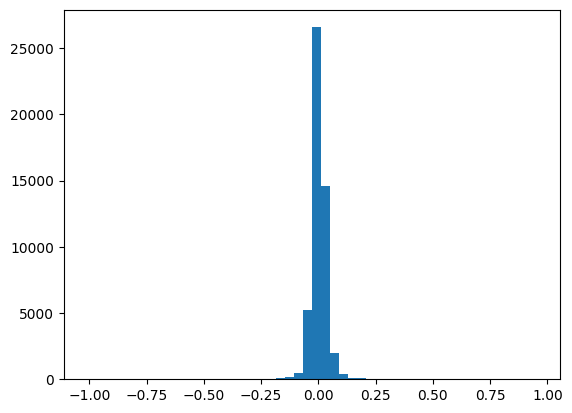

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584
Testing % outside of range: 0.501
Feature importances:
   slope_center_to_center_nearest_neighbor_distance_mean: 606.0
   slope: 438.0
   center_to_center_nearest_neighbor_distance_mean: 342.0
   exp_mean_r_center_to_center_nearest_neighbor_distance_mean: 342.0
   slope_exp_mean_r: 169.0
   exp_mean_r_areal_density: 138.0
   r_stat_multiplier: 47.0
   exp_mean_r: 47.0
   effective_radius_multiplier: 33.0
   za: 32.0
   exp_mean_r_n_craters_in_study_region: 32.0
   areal_density: 29.0
   min_rim_percentage: 28.0
   center_to_center_nearest_neighbor_distance_stdev: 26.0
   n_craters_in_study_region: 24.0
   radius_mean: 23.0
   z: 22.0
   center_to_center_nearest_neighbor_distance_min: 16.0
   center_to_center_nearest_neighbor_distance_max: 15.0
   areal_density_overlap_3: 14.0
   radius_stdev: 14.0
   areal_density_overlap_2: 13.0


In [11]:
# Small model first
poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[ivs])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    # .setObjective('quantile')
     .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.1)
    .setNumIterations(50)
    .setNumLeaves(50)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, ivs, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_50_50 = model

RMSE: 0.0246, MAE: 0.0135, MAPE: 0.0452


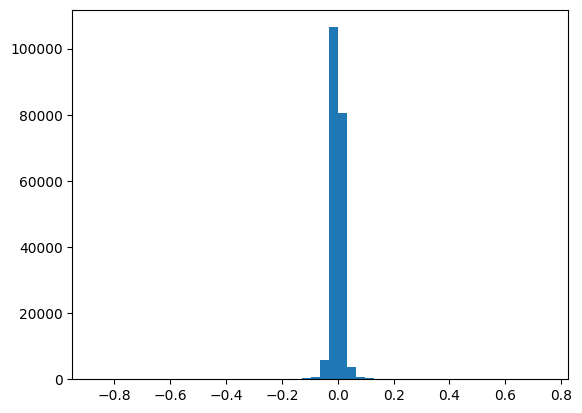

Mean model: RMSE: 0.1504, MAE: 0.0940, MAPE: 0.2980
Training % outside of range: 0.496
RMSE: 0.0337, MAE: 0.0168, MAPE: 0.0421


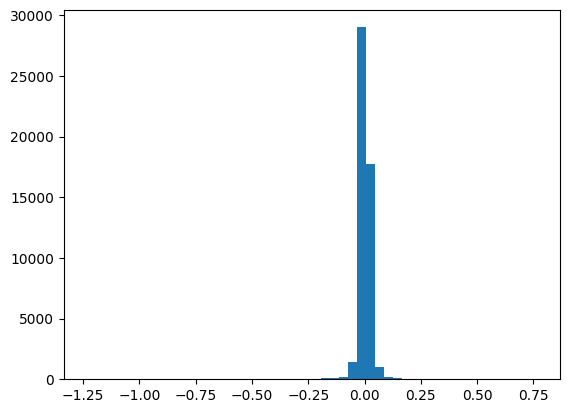

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584
Testing % outside of range: 0.486
Feature importances:
   slope: 1118.0
   center_to_center_nearest_neighbor_distance_mean: 1093.0
   slope_center_to_center_nearest_neighbor_distance_mean: 789.0


In [12]:
# Current best model

vars = [
    "slope_center_to_center_nearest_neighbor_distance_mean",
    "slope",
    "center_to_center_nearest_neighbor_distance_mean",
]

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[vars])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
     .setObjective('regression')
    .setLabelCol(metric)
    .setLearningRate(0.5)
    .setNumIterations(100)
    .setMaxDepth(25)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, vars, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, vars, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_100_depth_25 = model

RMSE: 0.0348, MAE: 0.0143, MAPE: 0.0511


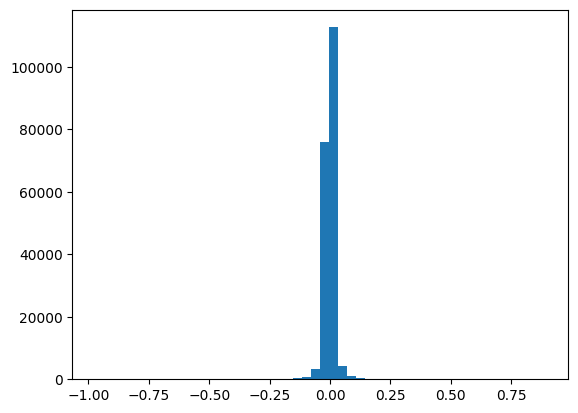

Mean model: RMSE: 0.1504, MAE: 0.0940, MAPE: 0.2980
Training % outside of range: 0.500
RMSE: 0.0402, MAE: 0.0175, MAPE: 0.0486


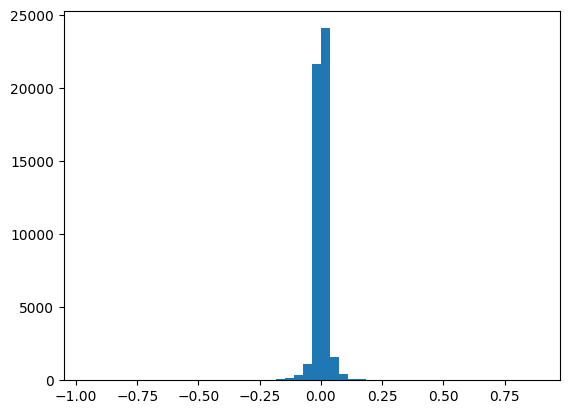

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584
Testing % outside of range: 0.499
Feature importances:
   center_to_center_nearest_neighbor_distance_mean: 1122.0
   slope: 1018.0
   slope_center_to_center_nearest_neighbor_distance_mean: 860.0


In [13]:
# Current best model

vars = [
    "slope_center_to_center_nearest_neighbor_distance_mean",
    "slope",
    "center_to_center_nearest_neighbor_distance_mean",
]

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[vars])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(0.5)
    .setNumIterations(100)
    .setMaxDepth(25)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, vars, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, vars, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_100_depth_25_median = model

RMSE: 0.0746, MAE: 0.0363, MAPE: 0.0827


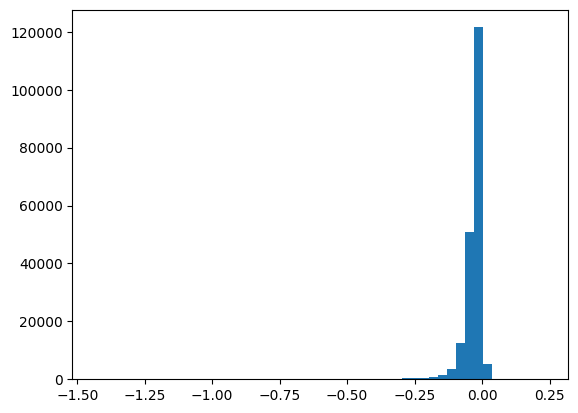

Mean model: RMSE: 0.1504, MAE: 0.0940, MAPE: 0.2980
Training % outside of range: 0.951
RMSE: 0.0784, MAE: 0.0378, MAPE: 0.0804


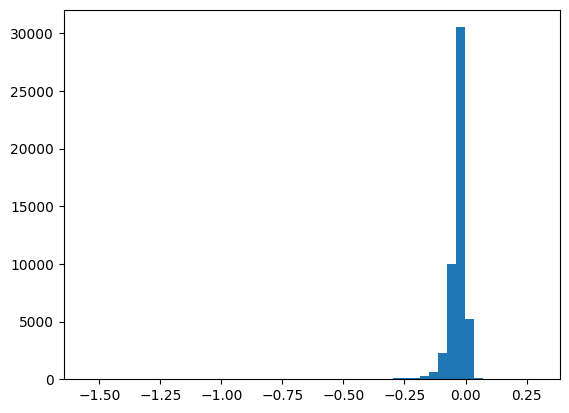

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584
Testing % outside of range: 0.924
Feature importances:
   slope: 1040.0
   center_to_center_nearest_neighbor_distance_mean: 1012.0
   slope_center_to_center_nearest_neighbor_distance_mean: 948.0


In [14]:
# Current best model

vars = [
    "slope_center_to_center_nearest_neighbor_distance_mean",
    "slope",
    "center_to_center_nearest_neighbor_distance_mean",
]

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[vars])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.95)
    .setLearningRate(0.5)
    .setNumIterations(100)
    .setMaxDepth(25)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, vars, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, vars, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_100_depth_25_95p = model

In [ ]:
# Current best model

vars = [
    "slope_center_to_center_nearest_neighbor_distance_mean",
    "slope",
    # "exp_mean_r",
    "center_to_center_nearest_neighbor_distance_mean",
    # "n_craters_in_study_region"
]

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[vars])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.05)
    .setLearningRate(0.5)
    .setNumIterations(100)
    .setMaxDepth(25)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, vars, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, vars, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

model_reg_100_depth_25_5p = model

### Plot Predictions

RMSE: 0.0265, MAE: 0.0141, MAPE: 0.0462


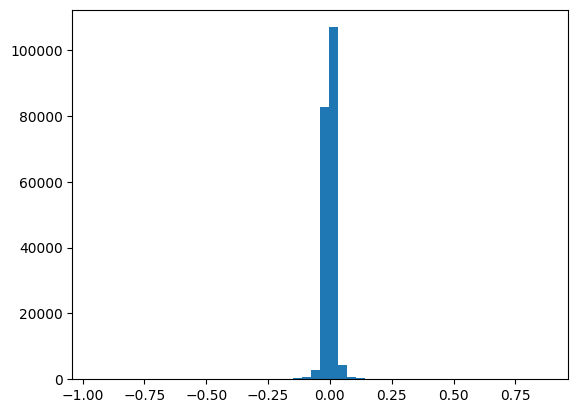

Mean model: RMSE: 0.1504, MAE: 0.0940, MAPE: 0.2980
Training % outside of range: 0.498
RMSE: 0.0355, MAE: 0.0177, MAPE: 0.0448


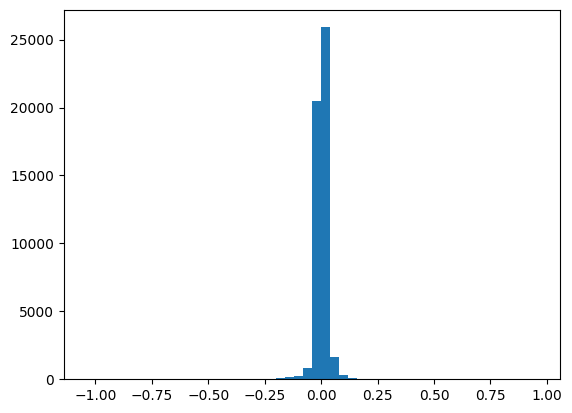

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584
Testing % outside of range: 0.487
Feature importances:
   slope: 1111.0
   center_to_center_nearest_neighbor_distance_mean: 1105.0
   slope_center_to_center_nearest_neighbor_distance_mean: 784.0


In [15]:
# Current best model

vars = [
    "slope_center_to_center_nearest_neighbor_distance_mean",
    "slope",
    "center_to_center_nearest_neighbor_distance_mean",
]

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[vars])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('regression')
    .setLabelCol(metric)
    # .setAlpha(0.5)
    .setLearningRate(0.5)
    .setNumIterations(100)
    .setMaxDepth(25)
    .setMinDataInLeaf(50)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

# Metrics for all train data
pred_df = score_model(model, train_df, metric, assembler, vars, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
print(f"Training % outside of range: {pred_df.outside_range.mean():.3f}")

# Metrics for all test data
pred_df = score_model(model, test_df, metric, assembler, vars, list(X_train.columns))
pred_df["outside_range"] = pred_df[metric] < pred_df.prediction
pred_df.outside_range.mean()
print(f"Testing % outside of range: {pred_df.outside_range.mean():.3f}")

importances = sorted(zip(X_train.columns, model.getFeatureImportances()), key=lambda x: -x[1])
print(f"Feature importances:")
for x in importances:
    print(f"   {x[0]}: {x[1]}")

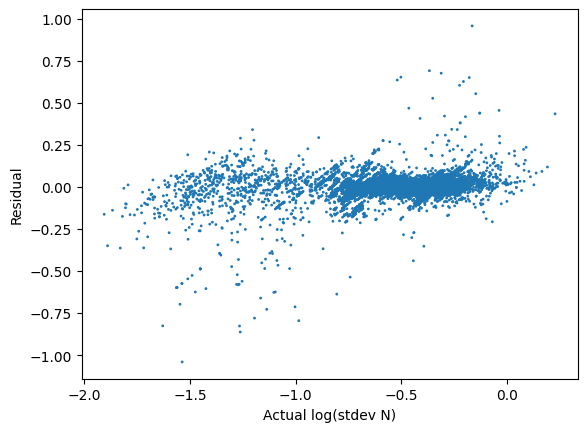

In [16]:
plt.scatter(pred_df[metric], pred_df[metric] - pred_df.prediction, sizes=[1] * pred_df.shape[0])
plt.xlabel("Actual log(stdev N)")
plt.ylabel("Residual")
plt.show()

### Plots of 95% CI

In [20]:
min_data_in_leaf = 50
learning_rate = 0.5
n_iterations = 100
max_depth = 25
n_cores = 20

vars = [
    "slope_center_to_center_nearest_neighbor_distance_mean",
    "slope",
    # "exp_mean_r",
    "center_to_center_nearest_neighbor_distance_mean",
    # "n_craters_in_study_region"
]

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=1, include_bias=False)
X_train = poly_transform.fit_transform(train_df[vars])
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

train_df_spark = spark.createDataFrame(pd.concat([train_df[metric], X_train], axis=1))

assembler = VectorAssembler(
    inputCols=list(X_train.columns),
    outputCol="features")

train_df_featurized = assembler.transform(train_df_spark)[metric, "features"].cache()

model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.025)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setMaxDepth(max_depth)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_2_5_quantile = model

In [21]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.5)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setMaxDepth(max_depth)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_50_quantile = model

In [22]:
model = (LightGBMRegressor()
    .setObjective('quantile')
    .setLabelCol(metric)
    .setAlpha(0.975)
    .setLearningRate(learning_rate)
    .setNumIterations(n_iterations)
    .setMaxDepth(max_depth)
    .setMinDataInLeaf(min_data_in_leaf)
    .setNumThreads(n_cores)
    .fit(train_df_featurized))

model_97_5_quantile = model

RMSE: 0.0753, MAE: 0.0438, MAPE: 0.1541


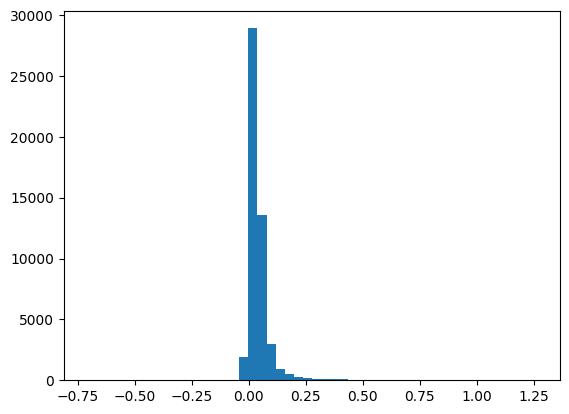

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584
RMSE: 0.0412, MAE: 0.0175, MAPE: 0.0491


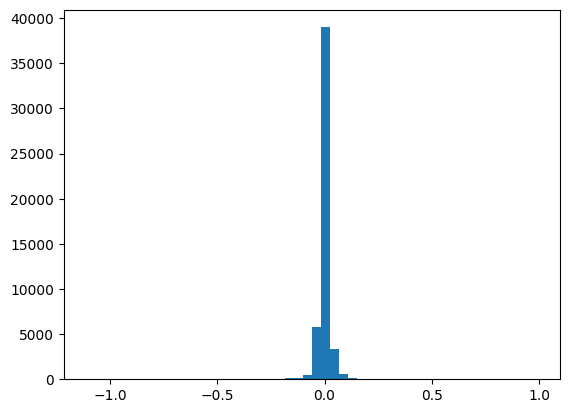

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584
RMSE: 0.0859, MAE: 0.0440, MAPE: 0.0924


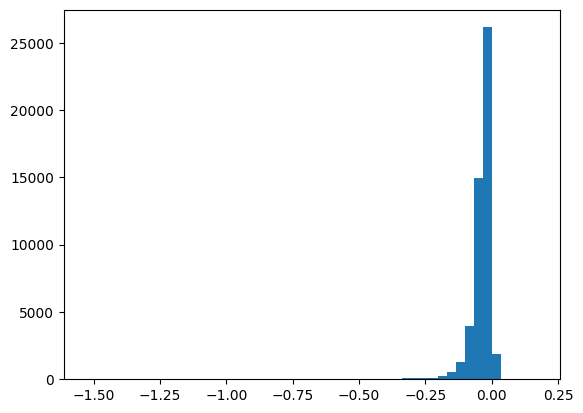

Mean model: RMSE: 0.1509, MAE: 0.0976, MAPE: 0.2584


In [24]:
pred_df_2_5_quantile = score_model(model_2_5_quantile, test_df, metric, assembler, vars, list(X_train.columns))
pred_df_50_quantile = score_model(model_50_quantile, test_df, metric, assembler, vars, list(X_train.columns))
pred_df_97_5_quantile = score_model(model_97_5_quantile, test_df, metric, assembler, vars, list(X_train.columns))

pred_df = pred_df_2_5_quantile.copy()
pred_df["prediction_2.5_quantile"] = pred_df["prediction"]
pred_df["prediction_50_quantile"] = pred_df_50_quantile["prediction"]
pred_df["prediction_97.5_quantile"] = pred_df_97_5_quantile["prediction"]
pred_df["slope"] = test_df["slope"]
pred_df["effective_radius_multiplier"] = test_df["effective_radius_multiplier"]
pred_df["min_rim_percentage"] = test_df["min_rim_percentage"]

slope                          1.015094
effective_radius_multiplier    1.525966
min_rim_percentage             0.466853
Name: 0, dtype: object


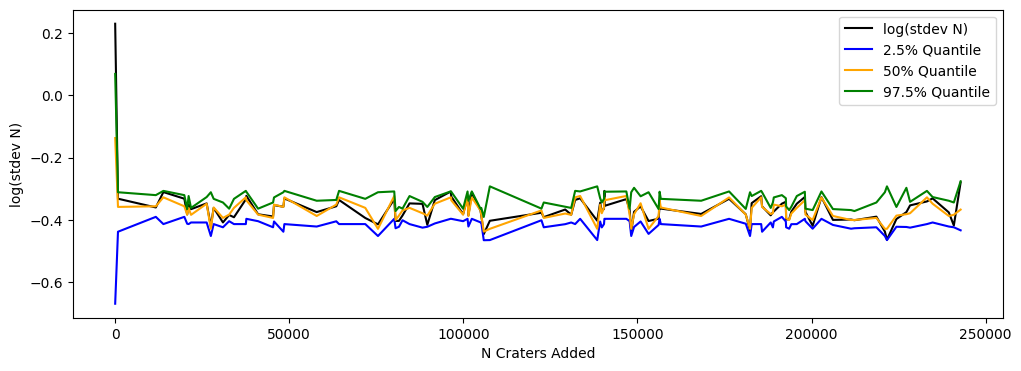

slope                          1.370926
effective_radius_multiplier    1.627658
min_rim_percentage             0.250126
Name: 1, dtype: object


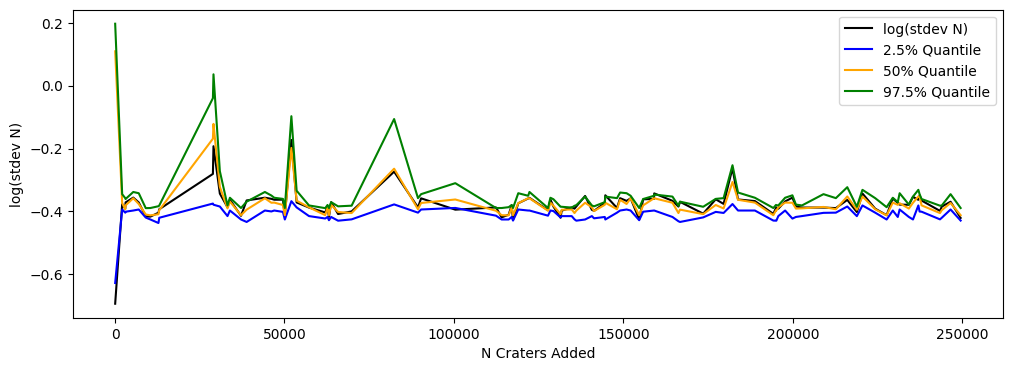

slope                          1.778307
effective_radius_multiplier    1.118717
min_rim_percentage             0.477817
Name: 2, dtype: object


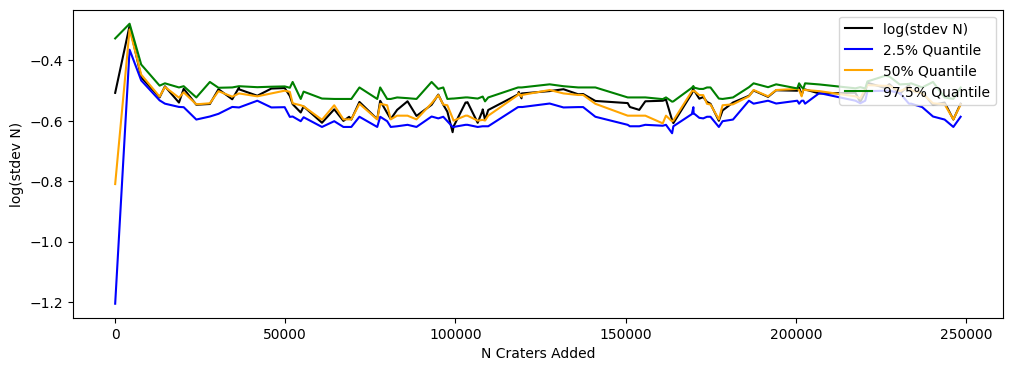

slope                          1.514875
effective_radius_multiplier    1.166512
min_rim_percentage             0.675956
Name: 3, dtype: object


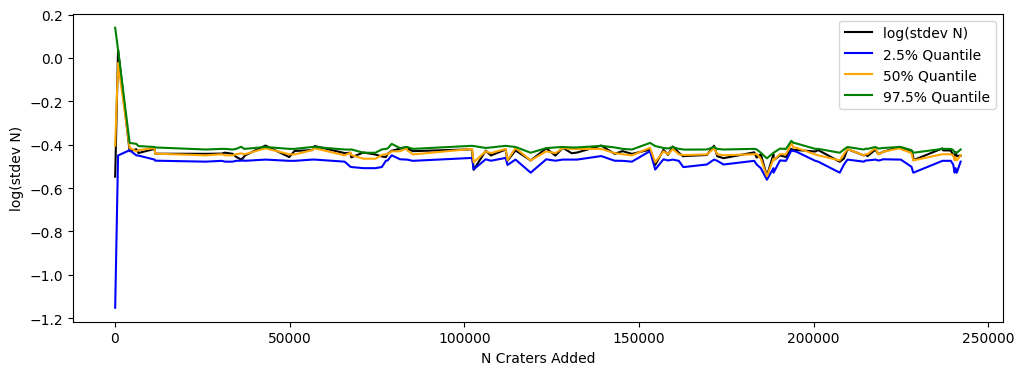

slope                          1.155412
effective_radius_multiplier    1.252512
min_rim_percentage             0.442758
Name: 4, dtype: object


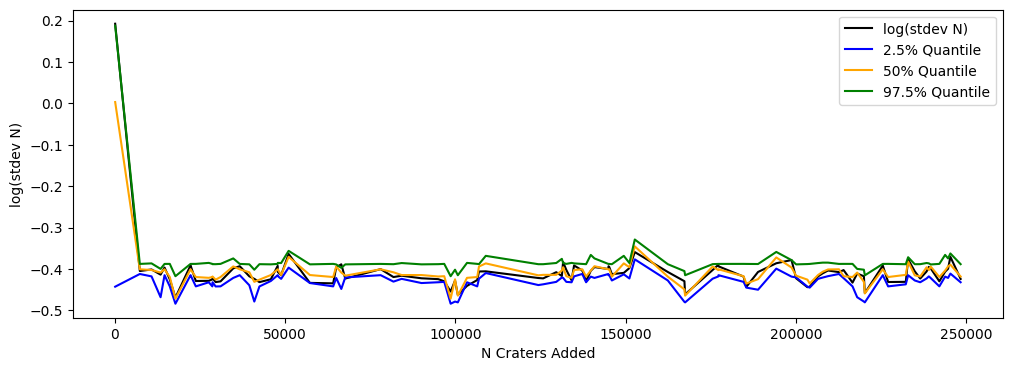

In [26]:
simulation_ids = list(pred_df.simulation_id.unique())

for x in simulation_ids[:5]:
    df = pred_df[pred_df.simulation_id == x].copy()
    print(df.iloc[0][["slope", "effective_radius_multiplier", "min_rim_percentage"]])
    df = df.sort_values("n_craters_added_in_study_region")
    
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.log_stdev_N, color='black', label="log(stdev N)")
    plt2 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_2.5_quantile"], color='blue', label="2.5% Quantile")
    plt3 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_50_quantile"], color='orange', label="50% Quantile")
    plt4 = ax1.plot(df.n_craters_added_in_study_region, df["prediction_97.5_quantile"], color='green', label="97.5% Quantile")
    ax1.set_xlabel("N Craters Added")
    ax1.set_ylabel("log(stdev N)")
    
    lns = plt1 + plt2 + plt3 + plt4
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("effective_radius_multiplier")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["effective_radius_multiplier"], resid, sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Eff Rad Mult")
plt.ylabel("Residual")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("min_rim_percentage")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["min_rim_percentage"], resid, sizes=[1] * pred_sorted.shape[0])
plt.xlabel("Min Rim Percentage")
plt.ylabel("Residual")
plt.show()

In [ ]:
pred_sorted = pred_df.sort_values("min_rim_percentage")
resid = (pred_sorted["prediction_50_quantile"] - pred_sorted[metric])

plt.scatter(pred_sorted["slope"], resid, sizes=[1] * pred_sorted.shape[0])
plt.xlabel("slope")
plt.ylabel("Residual")
plt.show()